In [1]:
!pip -q install segmentation-models
!git clone -q https://github.com/mateobentura/acoustic-deep-incremental-learning.git
!mv acoustic-deep-incremental-learning/* .; rm -rf acoustic-deep-incremental-learning

     |████████████████████████████████| 50 kB 6.9 MB/s 


In [2]:
import sys
import ImageSynthetique as imsy
from ImageSynthetique import timing
import Dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import gc
import skimage
from tensorflow import keras
from skimage.util import view_as_windows
import tensorflow as tf
import segmentation_models as sm
import matplotlib.patches as patches
img_shape = (32, 32)

Segmentation Models: using `tf.keras` framework.


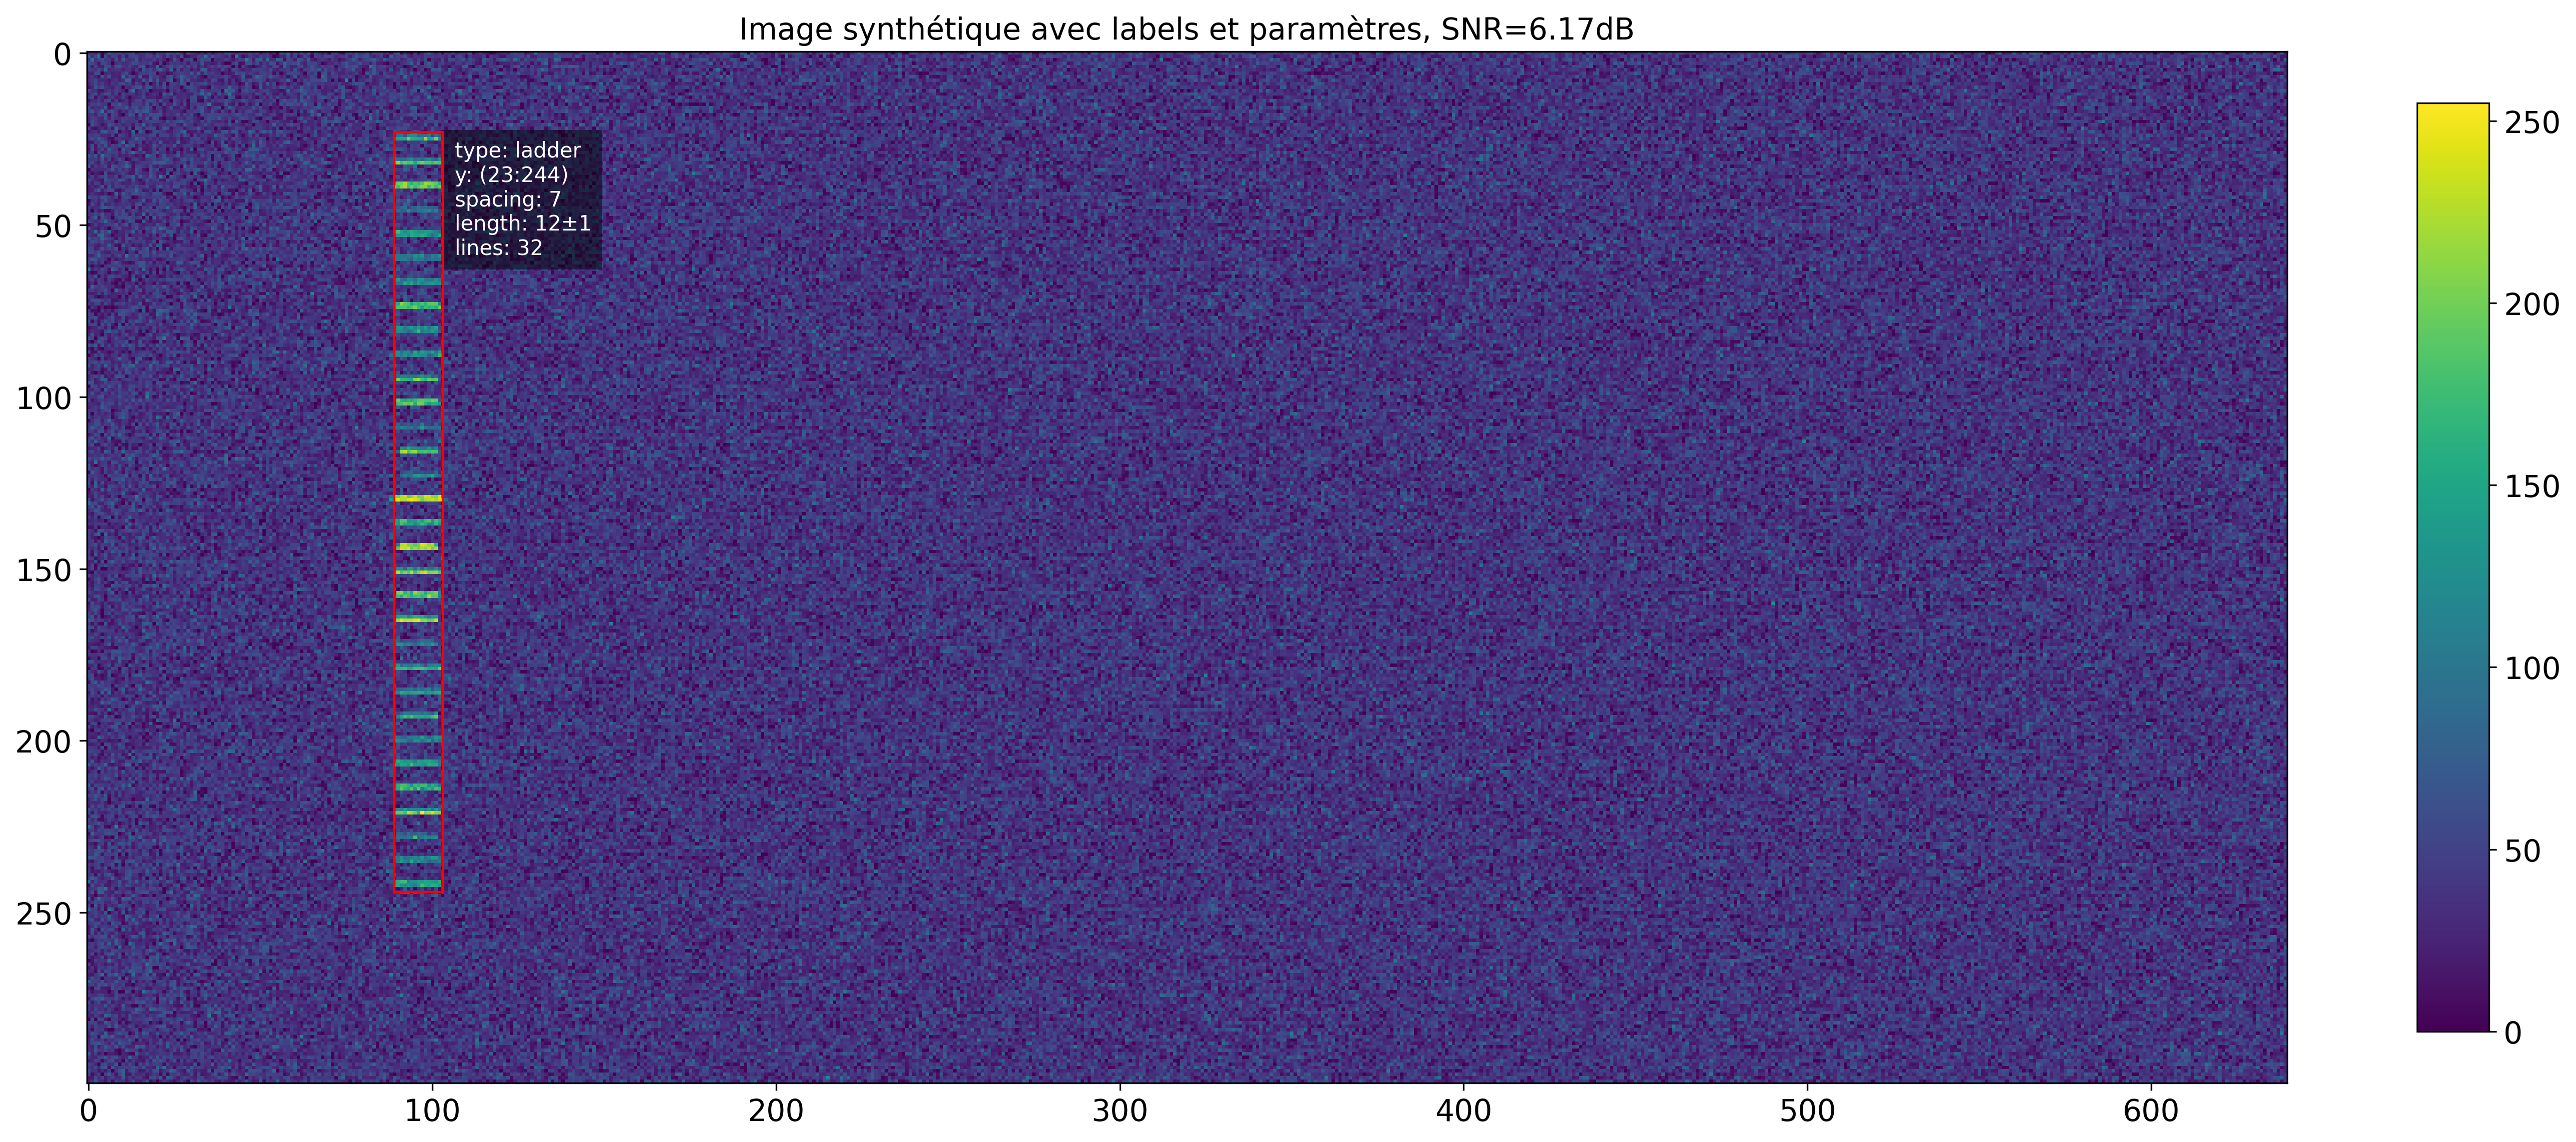

In [3]:
height, width = (300, 640)
train = imsy.ImageSynthetique(height, width, noise_lvl=0.15, seed=40)
train.add_ladder(starting_pt=[24 * 4, 25],
                spacing=7, length=12, l_var=1, lines=32)
train.finish()
train.show()

## Train

### Classification

In [7]:
def get_class_weight(labels):
    print('==================')
    print('Dataset statistics')
    print('==================')
    neg, pos = np.bincount(((labels.reshape(-1))/labels.max()).astype(int))
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))

    weight_0 = (1 / neg) * (total / 2.0)
    weight_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_0, 1: weight_1}

    print('Weight for class 0: {:.2f}'.format(weight_0))
    print('Weight for class 1: {:.2f}'.format(weight_1))
    return class_weight

In [14]:
var_time = timing()
classification_model = ds.classification_model(img_shape, dropout=True)
gc.collect()
var_time = timing('Model instancing', var_time)
train.sliding_window(32, 1, 1, 'classif')
class_weight = get_class_weight(train.labels['classif'])

ds_train, ds_val= train.crops_to_dataset(split=True)
print('=======================')
print('Classification training')
print('=======================')
print('Loss to be used: '+classification_model.compiled_loss._user_losses)
classification_history = classification_model.fit(ds_train.batch(72), epochs=10, validation_data=ds_val.batch(32), class_weight=class_weight)
var_time = timing('Classification training', var_time)
classification_model.save_weights('classif/classif')

Model instancing took 0m2.09s
Dataset statistics
Examples:
    Total: 163821
    Positive: 11270 (6.88% of total)

Weight for class 0: 0.54
Weight for class 1: 7.27
Classification training
Loss to be used: binary_crossentropy
Epoch 1/10
1821/1821 [==============================] - 86s 45ms/step - loss: 0.8545 - dice_coef: 0.8524 - acc: 0.9613 - sensitivity: 0.7202 - specificity: 0.7251 - val_loss: 0.1330 - val_dice_coef: 0.9846 - val_acc: 0.9900 - val_sensitivity: 0.9918 - val_specificity: 0.8651
Epoch 2/10
1821/1821 [==============================] - 81s 44ms/step - loss: 0.3088 - dice_coef: 0.9419 - acc: 0.9048 - sensitivity: 0.8991 - specificity: 0.8249 - val_loss: 0.1333 - val_dice_coef: 0.9841 - val_acc: 0.9890 - val_sensitivity: 0.9904 - val_specificity: 0.8780
Epoch 3/10
1821/1821 [==============================] - 82s 45ms/step - loss: 0.2457 - dice_coef: 0.9576 - acc: 0.9415 - sensitivity: 0.9391 - specificity: 0.8475 - val_loss: 0.1204 - val_dice_coef: 0.9860 - val_acc: 0.990

### Segmentation

In [9]:
train.sliding_window(32, 1, 1)
preprocessing_fn = sm.get_preprocessing('resnet34')
crops = train.crops.reshape(-1,32,32,1)
crops = preprocessing_fn(crops)
labels = train.labels['segm'].reshape(-1,32,32,train.classes)/255.
# ds_train = tf.data.Dataset.from_tensor_slices((crops, labels))
# ds_train = ds_train.prefetch(64)
# del crops, labels
gc.collect()
segmentation_model = ds.segmentation_model(img_shape, backbone='resnet34')
segmentation_model
history = segmentation_model.fit(crops, labels, epochs=4)
# del ds_train
segmentation_model.save_weights('segm/segm')

Epoch 1/4
5120/5120 [==============================] - 222s 42ms/step - loss: 0.1637 - dice_coef: 0.9995 - acc: 0.9989 - sensitivity: 0.8930 - specificity: 0.9993
Epoch 2/4
5120/5120 [==============================] - 219s 43ms/step - loss: 0.0785 - dice_coef: 0.9998 - acc: 0.9996 - sensitivity: 0.9568 - specificity: 0.9998
Epoch 3/4
5120/5120 [==============================] - 218s 43ms/step - loss: 0.0697 - dice_coef: 0.9998 - acc: 0.9997 - sensitivity: 0.9602 - specificity: 0.9999
Epoch 4/4
5120/5120 [==============================] - 219s 43ms/step - loss: 0.0706 - dice_coef: 0.9999 - acc: 0.9997 - sensitivity: 0.9683 - specificity: 0.9999


31700

#Test

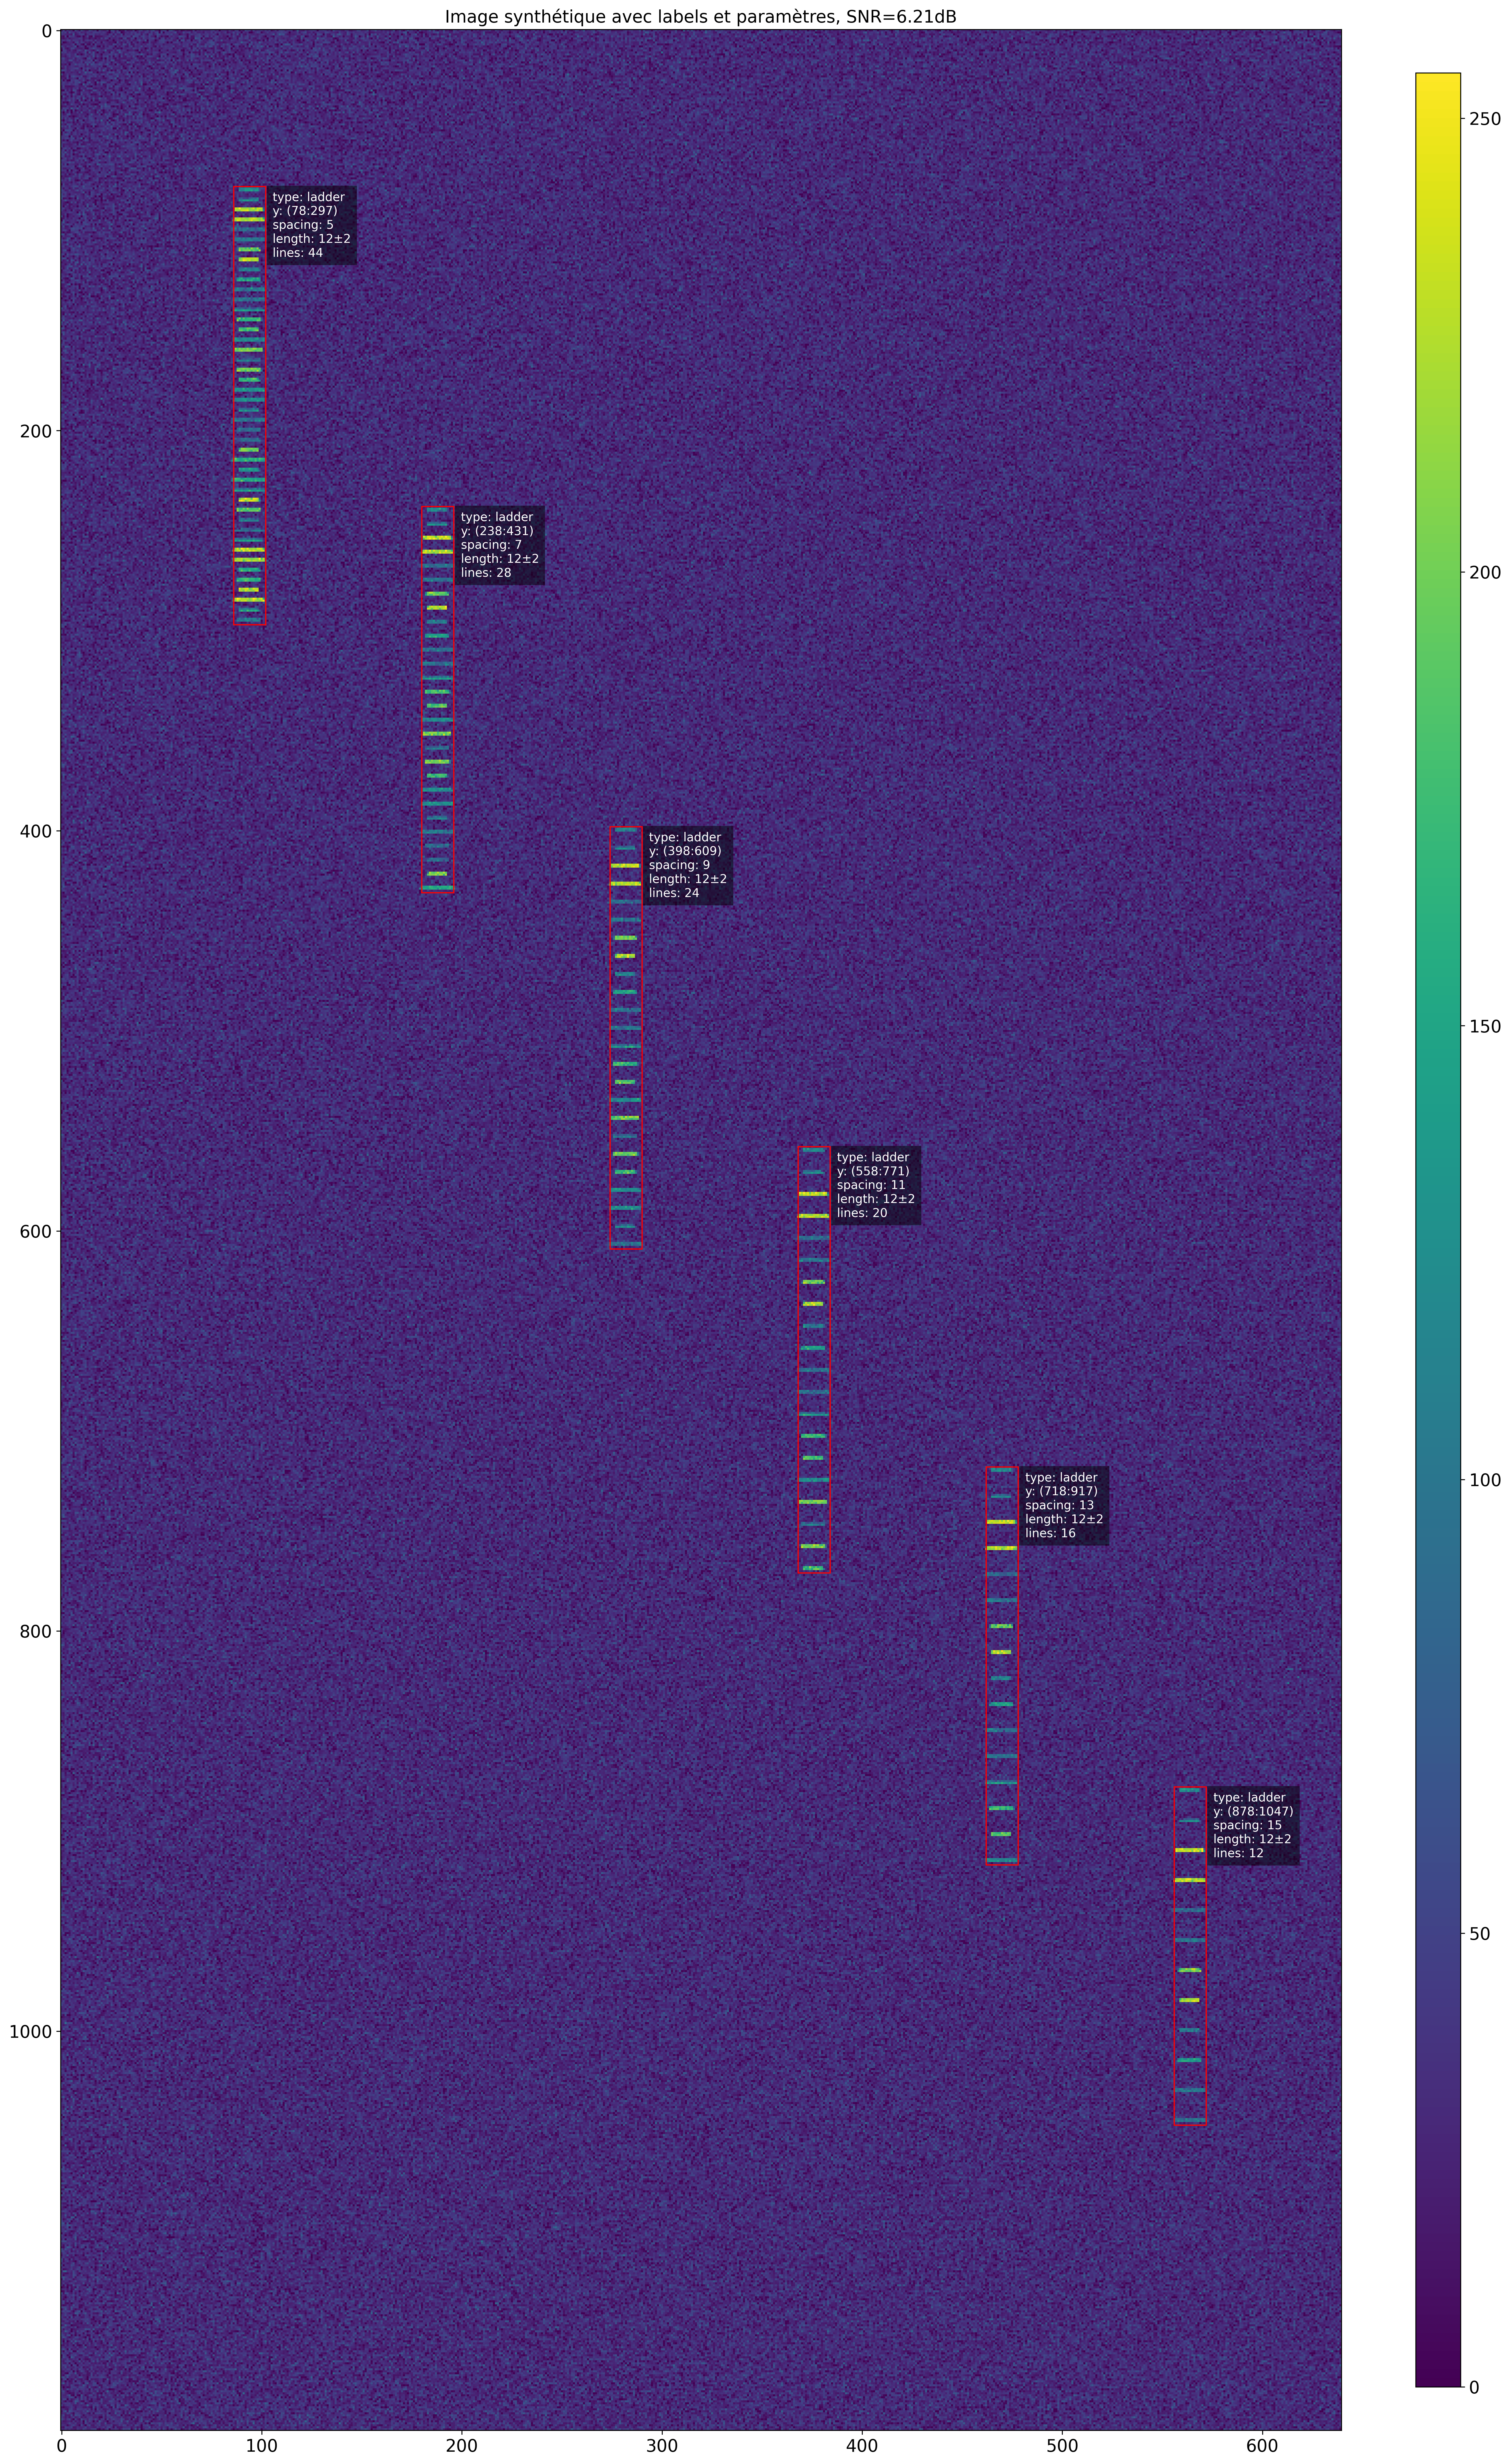

In [11]:
seed = 30
test = imsy.ImageSynthetique(1200, noise_lvl=0.12, seed=seed)
spacings = [5, 7, 9, 11, 13, 15]
for spacing in spacings:
    pt = [47*(spacing-3), 80*(spacing-4)]
    test.add_ladder(starting_pt=pt,
                    spacing=spacing, length=12,
                    l_var=2, lines=4*(55//spacing), seed=seed)
test.finish()
test.show()

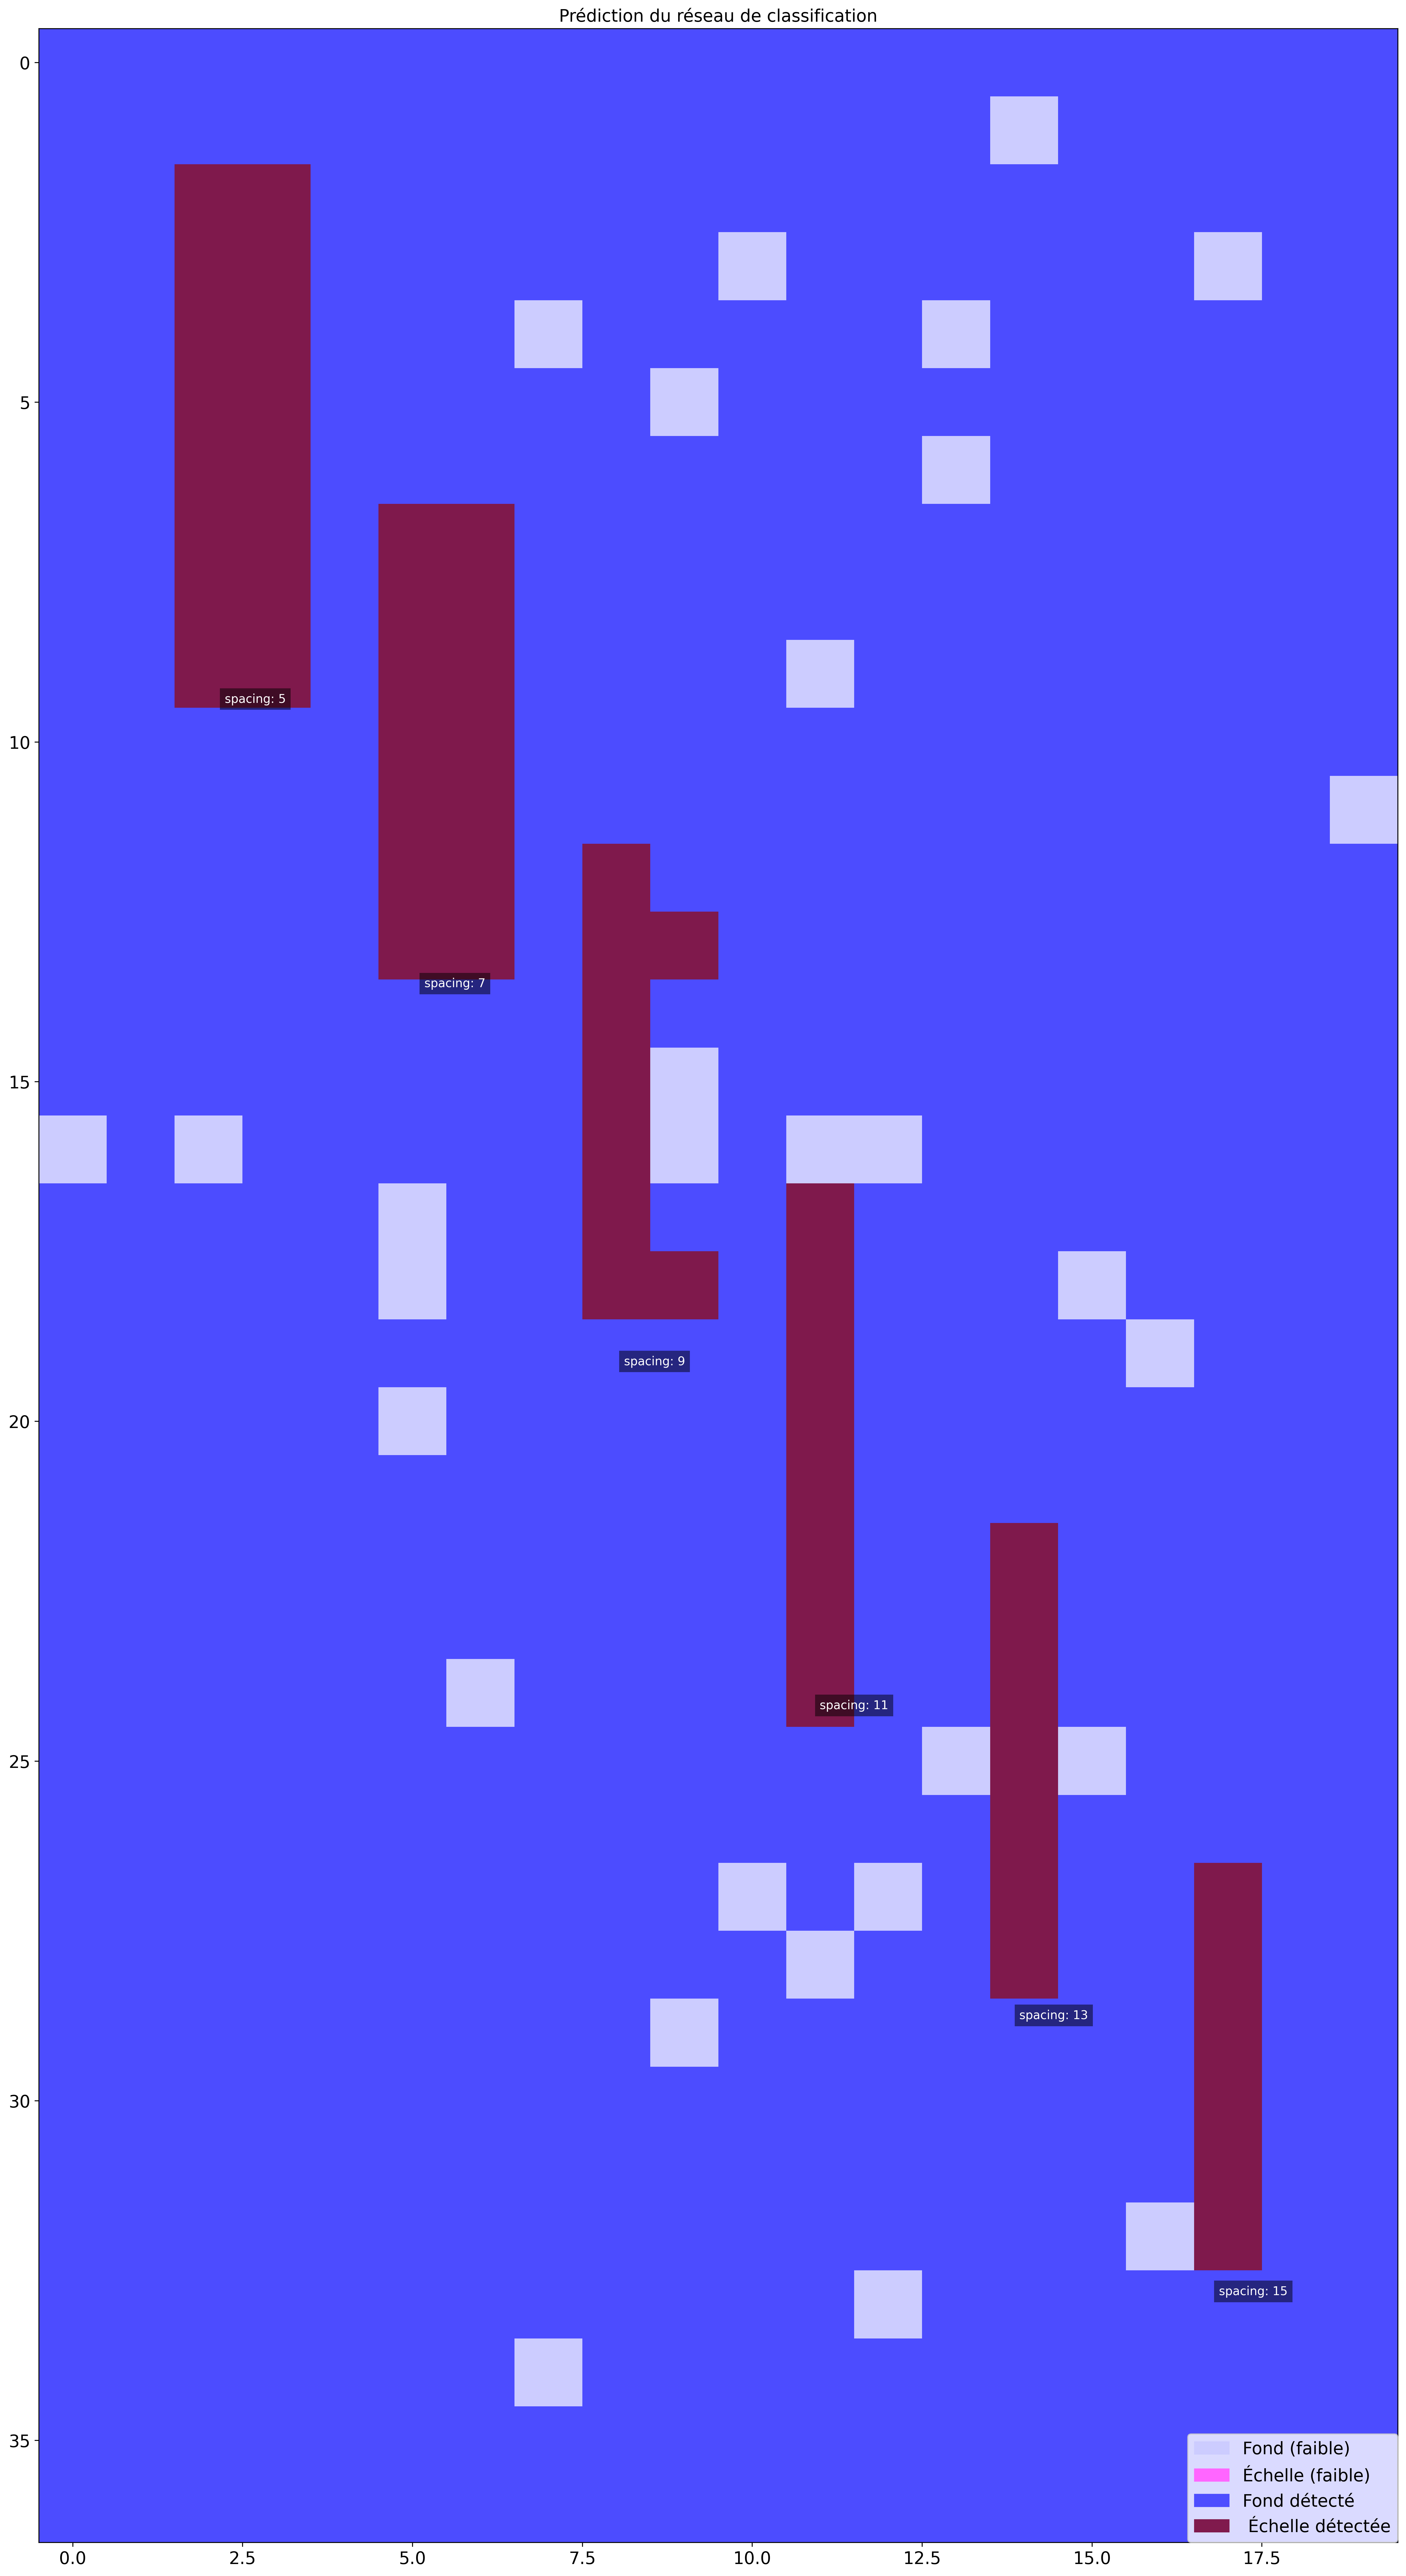

Test avec le modèle classification
Exemples avec une réponse forte: 710


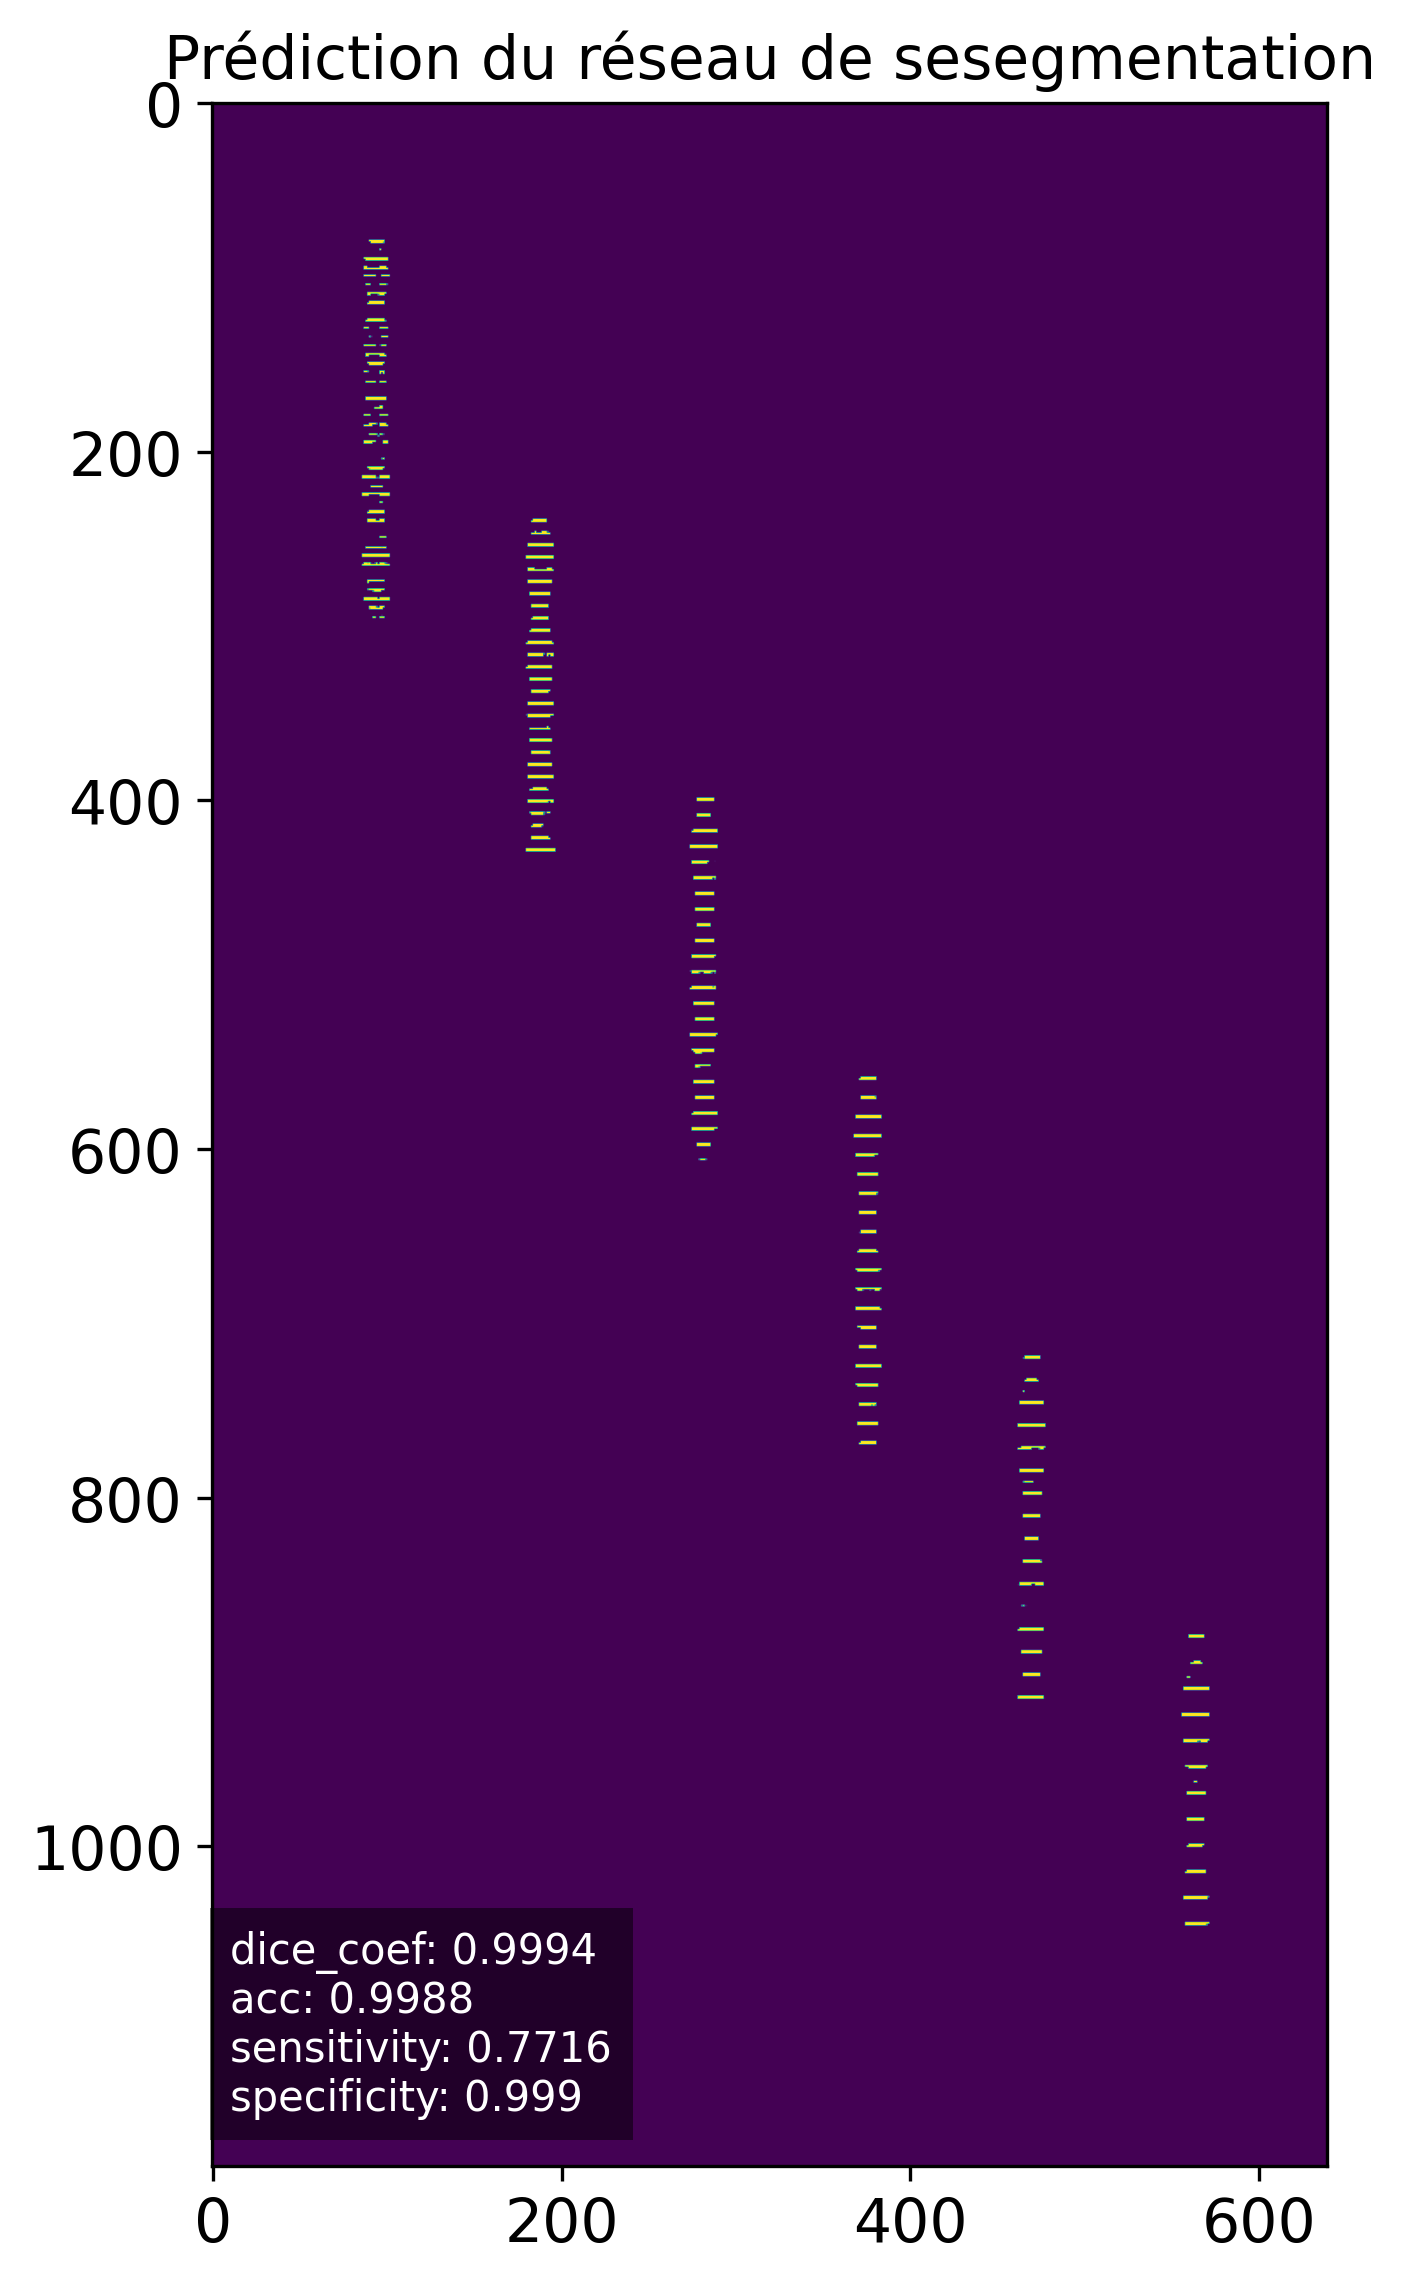

In [15]:
test.sliding_window(32,32,32)
test.test_train(classification_model, segmentation_model)

In [17]:
!zip weights.zip classif/* segm/*

  adding: classif/checkpoint (deflated 37%)
  adding: classif/classif.data-00000-of-00001 (deflated 8%)
  adding: classif/classif.index (deflated 81%)
  adding: segm/checkpoint (deflated 35%)
  adding: segm/segm.data-00000-of-00001 (deflated 50%)
  adding: segm/segm.index (deflated 81%)
